### 三、投资策略

#### 2、配置策略：风险平价（Risk Parity）模型

风险平价（Risk Parity）理论是当代资产配置理论中的一种，该理论是先出现在金融市场实践，再被发展成理论的：早在1996年，桥水基金（Bridgewater Associates）就推出了应用该策略的产品，也就是后来大名鼎鼎的“全天候策略基金”（All weather strategy fund）。2005年，PanAgora Asset Management的CIO和研究主管Edward Qian博士发表了文章《On the Financial Interpretation of Risk: Risk Budgets do add up》，被广泛认为是“风险平价”概念的第一次正式提出和构建方式的数理化。

对于投资组合，其收益率和风险，可按以下公式表示：
$$r_{p}= \sum_{i=1}^{n} w_{i} \cdot r_{i}$$
$$\sigma_{p}= \sqrt {\sum_{i=1}^{n}  \sum_{j=1}^{n} w_{i} \cdot w_{j} \cdot \sigma_{ij}}$$

单个资产对投资组合的风险贡献，以MC表示，计算如下：
$$MC_{i}=w_{i} \cdot \frac{\sum_{j=1}^{n} w_{j} \cdot \sigma_{ij}}{\sigma_{p}}$$
$$\sigma_{p}=\sum_{i=1}^{n} MC_{i}$$

为每个资产预先确定风险权重，可计算每个资产在投资组合里的配置权重，定期更新资产数据，调整投资组合的配置。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
import time
import requests
from itertools import combinations
from IPython.core.display import HTML

In [2]:
# set end_date
end_date = '2018-12-31'
comparable_ticker = 'SPY'

In [3]:
def read_csv(etf_ticker):
    csv_filename = etf_ticker[0]+end_date+'.csv'
    df = pd.read_csv(csv_filename)
    p_t=['Date','Adj Close']
    p=df[p_t].sort_values(by='Date')
    p['Date'] = pd.to_datetime(p['Date'])
    p.set_index("Date", inplace=True)
    p = p.rename({'Adj Close':etf_ticker[0]}, axis=1)
    pl=p

    for i in range(1,len(etf_ticker)):
        csv_filename = etf_ticker[i]+end_date+'.csv'
        df = pd.read_csv(csv_filename)    
        p=df[p_t].sort_values(by='Date')
        p['Date'] = pd.to_datetime(p['Date'])
        p.set_index("Date", inplace=True)
        p = p.rename({'Adj Close':etf_ticker[i]}, axis=1)
        pl = pd.merge(pl,p,left_index=True, right_index=True)
        
    return pl

In [4]:
from scipy.optimize import minimize
TOLERANCE = 1e-10


def _allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]

    # It returns the risk of the weights distribution
    return portfolio_risk


def _assets_risk_contribution_to_allocation_risk(weights, covariances):

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
        / portfolio_risk

    # It returns the contribution of each asset to the risk of the weights
    # distribution
    return assets_risk_contribution


def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the
    # second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights
    # distribution
    assets_risk_contribution = \
        _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the
    # weights distribution
    assets_risk_target = \
        np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of
    # each asset
    error = \
        sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error


def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):

    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})

    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})

    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

In [5]:
def calc_mc(w,cov):
    mc=np.zeros(len(cov))
    for i in range(0,len(cov)):
        for j in range(0,len(cov)):
            mc[i]=mc[i]+w[i]*w[j]*cov[i][j]
    mc=mc/mc.sum()
    return mc

##### 1）静态计算

以相等风险权重作为配置目标，通过计算得到结果如下：

In [39]:
# 读取数据
etf_ticker=['SHY','SPY','XLE','XLF','XLRE','SPDW','SPEM']
pl=read_csv(etf_ticker)

In [40]:
# 计算投资组合中各资产参数
wp=pl.copy()
for e in etf_ticker:
    wp[e] = wp[e].pct_change()
wp = wp.drop(wp.index[0:1])

r=np.array(wp.mean())
s=np.array(wp.var())
cov=np.array(wp.cov())

In [41]:
#初始化权重
#等值
mc_budget = [1 / wp.shape[1]] * wp.shape[1]
#指定
#mc_budget = [0.4,0.2,0.1,0.1,0.1,0.1,0.0]
w0 = np.array([1 / wp.shape[1]] * wp.shape[1])

In [12]:
#计算权重
w = _get_risk_parity_weights(cov, mc_budget, w0)
mc=calc_mc(w,cov)
for i in range(0,len(w)):
    print(etf_ticker[i], 'weight at %0.2f%% with risk at %0.2f%%' %(w[i]*100, mc[i]*100))
yr=r*252
print('Expected Portfolio Return %0.2f%%' %(yr.dot(w.T)*100))

SPY weight at 12.11% with risk at 17.02%
SHY weight at 22.21% with risk at -0.71%
XLE weight at 9.20% with risk at 16.62%
XLF weight at 7.68% with risk at 15.90%
XLRE weight at 29.66% with risk at 19.41%
SPDW weight at 10.17% with risk at 15.57%
SPEM weight at 8.98% with risk at 16.19%
Expected Portfolio Return 5.05%


##### 2）动态配置回测

以相等风险权重作为配置目标，每周动态调整权重。

In [42]:
# 读取数据
etf_ticker=['SHY','SPY','XLE','XLF']
pl=read_csv(etf_ticker)
portfolio = 'Protfolio'

In [43]:
#周线
wp = pl.resample('W', loffset=pd.offsets.timedelta(days=-6)).mean().dropna()
wr=wp.copy()
for e in etf_ticker:
    wr[e] = wr[e].pct_change()
wr = wr.drop(wr.index[0:1])
wp = wp.drop(wr.index[0:1])

In [44]:
mp=52
mc_budget = [1 / wp.shape[1]] * wp.shape[1]
w0 = np.array([1 / wp.shape[1]] * wp.shape[1])
ww=wr.copy()
for i in range(mp,len(wr)):
    tr=wr[i-mp:i]
    #r=np.array(tr.mean())
    #s=np.array(tr.var())
    cov=np.array(tr.cov())
    w = _get_risk_parity_weights(cov, mc_budget, w0)
    ww.iloc[i]=w
pr=wp*ww
pr['Sum']=pr.sum(axis=1)

In [45]:
pr=pr.drop(pr.index[0:mp+1])
ww=ww.drop(ww.index[0:mp+1])

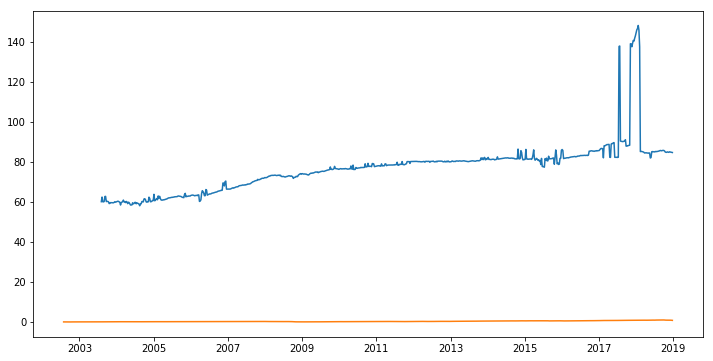

In [46]:
# Plot
# Normalize
from sklearn import preprocessing
wpn = wp
min_max_scaler = preprocessing.MinMaxScaler()
for c in wpn.columns:
    wpn[c]=min_max_scaler.fit_transform(wpn[c].astype(float).values.reshape(-1, 1))    

plt.figure(1,figsize=(12,6))
sns.lineplot(data=pr['Sum'])
sns.lineplot(data=wpn['SPY'])

In [47]:
wwc=ww.copy()
for i in range(1,len(etf_ticker)):
    wwc[etf_ticker[i]]=wwc[etf_ticker[i-1]]+ww[etf_ticker[i]]

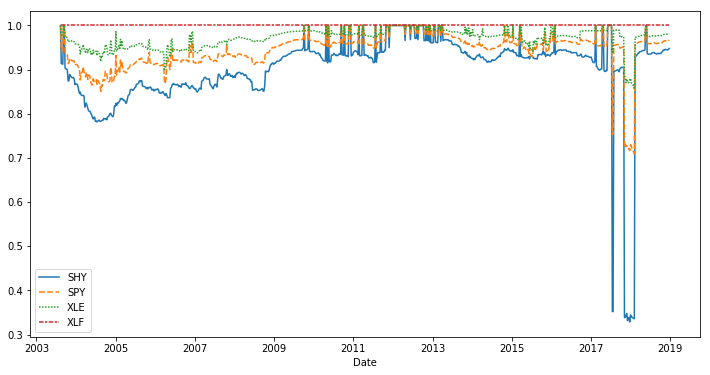

In [48]:
plt.figure(1,figsize=(12,6))
sns.lineplot(data=wwc)

In [38]:
wwa=ww.copy()

In [49]:
f=0.05
for i in range(1,len(wwa)):
    for e in range(1,len(etf_ticker)):
        if wwa[etf_ticker[i]]/wwa[etf_ticker[i-1]]>1+f:
            wwa[etf_ticker[i]]=(1+f)*wwa[etf_ticker[i-1]]
        elif wwa[etf_ticker[i]]/wwa[etf_ticker[i-1]]<1-f:
            wwa[etf_ticker[i]]=(1-f)*wwa[etf_ticker[i-1]]
            

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().